In [1]:
import numpy
import scipy.signal
import scipy.sparse

In [2]:
def Conv(x, W):
    wrow, wcol, numFilters = W.shape
    xrow, xcol, _ = x.shape
    
    yrow = xrow - wrow + 1
    ycol = xcol - wcol + 1
    
    y = numpy.zeros((yrow, ycol, numFilters))
    
    for k in range(numFilters):
        filterW = W[:, :, k]
        filterW = numpy.rot90(numpy.squeeze(filterW), 2)
        y[:, :, k] = scipy.signal.convolve2d(x[:, :, 0], filterW, 'valid')
        
    return y

In [3]:
def Pool(x):
    xrow, xcol, numFilters = x.shape
    
    y = numpy.zeros((int(xrow/2), int(xcol/2), numFilters))
    
    for k in range(numFilters):
        filterW = numpy.ones((2, 2)) / (2*2)
        image = scipy.signal.convolve2d(x[:, :, k], filterW, 'valid')
        y[:, :, k] = image[0:image.shape[0]:2, 0:image.shape[1]:2]
    
    return y

In [4]:
def ReLU(x):
    return numpy.maximum(0, x)

In [5]:
def Softmax(x):
    ex = numpy.exp(numpy.array(x))
    return ex / sum(ex)

In [6]:
def MnistConv(W1, W5, Wo, X, D):
    alpha = 0.01
    beta = 0.95
    
    momentum1 = numpy.zeros(W1.shape)
    momentum5 = numpy.zeros(W5.shape)
    momentumo = numpy.zeros(Wo.shape)
    
    N = len(D)
    
    bsize = 100
    blist = [x for x in range(0, (N-bsize+1), bsize)]
    
    for batch in range(len(blist)):
        dW1 = numpy.zeros(W1.shape)
        dW5 = numpy.zeros(W5.shape)
        dWo = numpy.zeros(Wo.shape)
        
        begin = blist[batch]
        for k in range(begin, begin+bsize, 1):
            x = X[:, :, :, k]
            y1 = Conv(x, W1)
            y2 = ReLU(y1)
            y3 = Pool(y2)
            y4 = y3.flatten()
            v5 = numpy.dot(W5, y4)
            y5 = ReLU(v5)
            v = numpy.dot(Wo, y5)
            y = Softmax(v)
            
            d = numpy.zeros(10)
            d[D[k]] = 1
            
            e = d - y
            delta = e
            
            e5 = numpy.dot(Wo.T, delta)
            delta5 = (y5 > 0) * e5
            
            e4 = numpy.dot(W5.T, delta5)
            
            e3 = e4.reshape(y3.shape)
            
            e2 = numpy.zeros(y2.shape)
            W3 = numpy.ones(y2.shape) / (2*2)
            for c in range(20):
                e2[:, :, c] = scipy.sparse.kron(e3[:, :, c], numpy.ones((2, 2))) * W3[:, :, c]
                
            delta2 = (y2 > 0) * e2
            
            delta1_x = numpy.zeros(W1.shape)
            for c in range(20):
                delta1_x[:, :, c] = scipy.signal.convolve2d(x[:, :, 0], numpy.rot90(delta2[:, :, c], 2), 'valid')
                
            dW1 = dW1 + delta1_x
            dW5 = dW5 + numpy.outer(delta5, numpy.transpose(y4))
            dWo = dWo + numpy.outer(delta, numpy.transpose(y5))
            
            if k % 1000 == 0:
                print('k = ', k, ' W1 = ', numpy.sum(W1), ' W5 = ', numpy.sum(W5), ' dWo = ', numpy.sum(Wo))
        
        dW1 = dW1 / (bsize * 1000)
        dW5 = dW5 / (bsize * 1)
        dWo = dWo / (bsize * 1)
        
        momentum1 = alpha * dW1 + beta * momentum1
        W1 = W1 + momentum1
        
        momentum5 = alpha * dW5 + beta * momentum5
        W5 = W5 + momentum5
        
        momentumo = alpha * dWo + beta * momentumo
        Wo = Wo + momentumo

    return W1, W5, Wo

In [7]:
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

(Images, Labels), _ = load_mnist(flatten=False, normalize=False)

In [8]:
import math

W1 = 1e-2*numpy.random.randn(9, 9, 20)
W5 = (2*numpy.random.rand(100, 2000) - 1) * math.sqrt(6) / math.sqrt(360 + 2000)
Wo = (2*numpy.random.rand(10, 100) - 1) * math.sqrt(6) / math.sqrt(10 + 100)

In [9]:
num_Images = len(Images)
X = Images.transpose(2, 3, 1, 0).reshape(28, 28, 1, num_Images)[:, :, :, 0:8000]
D = Labels[0:8000]

In [10]:
for epoch in range(3):
    W1, W5, Wo = MnistConv(W1, W5, Wo, X, D)

k =  0  W1 =  -0.46857531578299005  W5 =  3.579330796815433  dWo =  5.359998474058488
k =  1000  W1 =  -33.33407012968216  W5 =  -1073.2819924109826  dWo =  5.359998474058491
k =  2000  W1 =  -55.67487573457011  W5 =  -1781.0117292976101  dWo =  5.359998474058486
k =  3000  W1 =  -69.36125047394344  W5 =  -2223.471449550728  dWo =  5.359998474058486
k =  4000  W1 =  -77.60500979760307  W5 =  -2507.8597136424005  dWo =  5.359998474058479
k =  5000  W1 =  -82.50994128233344  W5 =  -2685.3143737125865  dWo =  5.359998474058472
k =  6000  W1 =  -85.10655983478094  W5 =  -2817.7319490763653  dWo =  5.359998474058486
k =  7000  W1 =  -87.32262401773593  W5 =  -2955.2669096582867  dWo =  5.359998474058472
k =  0  W1 =  -88.67297276480409  W5 =  -3072.4574987567394  dWo =  5.359998474058479
k =  1000  W1 =  -87.97922605163053  W5 =  -3097.740030306669  dWo =  5.359998474058479
k =  2000  W1 =  -87.44752007578634  W5 =  -3152.8641627418947  dWo =  5.359998474058493
k =  3000  W1 =  -87.66500989

In [11]:
import pickle

fp = open("MnistConv.mat", "wb")
pickle.dump(W1, fp)
pickle.dump(W5, fp)
pickle.dump(Wo, fp)
fp.close()

In [17]:
num_Images = len(Images)
X = Images.transpose(2, 3, 1, 0).reshape(28, 28, 1, num_Images)[:, :, :, 8000:10000]
D = Labels[8000:10000]

In [18]:
acc = 0
N = len(D)
for k in range(N):
    x = X[:, :, :, k]
    y1 = Conv(x, W1)
    y2 = ReLU(y1)
    y3 = Pool(y2)
    y4 = y3.flatten()
    v5 = numpy.dot(W5, y4)
    y5 = ReLU(v5)
    v = numpy.dot(Wo, y5)
    y = Softmax(v)
    
    i = numpy.argmax(y)
    if i == D[k]:
        acc = acc + 1

acc = acc / N
print('Accuracy is = ', acc)

Accuracy is =  0.1755


In [19]:
fp = open("MnistConv.mat", "rb")
W1 = pickle.load(fp)
W5 = pickle.load(fp)
Wo = pickle.load(fp)
fp.close()

In [21]:
num_Images = len(Images)
X = Images.transpose(2, 3, 1, 0).reshape(28, 28, 1, num_Images)[:, :, :, 0:10]

k = 0
x = X[:, :, :, k]
y1 = Conv(x, W1)
y2 = ReLU(y1)
y3 = Pool(y2)
y4 = y3.flatten()
v5 = numpy.dot(W5, y4)
y5 = ReLU(v5)
v = numpy.dot(Wo, y5)
y = Softmax(v)

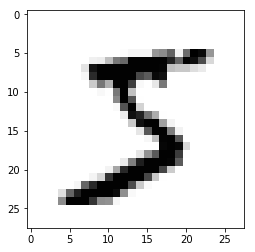

In [23]:
import matplotlib.pyplot
%matplotlib inline

matplotlib.pyplot.imshow(x[:, :, 0], cmap='Greys', interpolation='None')

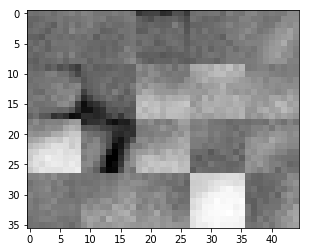

In [24]:
convFilters = numpy.zeros((9*4, 9*5))
i = 0
for j in range(4):
    for k in range(5):
        convFilters[9*j:9*(j+1), 9*k:9*(k+1)] = W1[:, :, i]
        i = i + 1
matplotlib.pyplot.imshow(convFilters, cmap='Greys', interpolation='None')

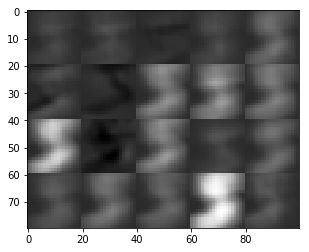

In [25]:
fList = numpy.zeros((20*4, 20*5))
i = 0
for j in range(4):
    for k in range(5):
        fList[20*j:20*(j+1), 20*k:20*(k+1)] = y1[:, :, i]
        i = i + 1
matplotlib.pyplot.imshow(fList, cmap='Greys', interpolation='None')

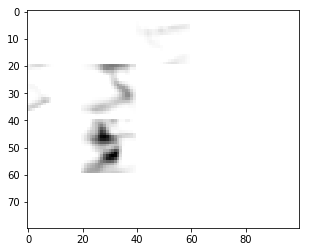

In [26]:
fList = numpy.zeros((20*4, 20*5))
i = 0
for j in range(4):
    for k in range(5):
        fList[20*j:20*(j+1), 20*k:20*(k+1)] = y2[:, :, i]
        i = i + 1
matplotlib.pyplot.imshow(fList, cmap='Greys', interpolation='None')

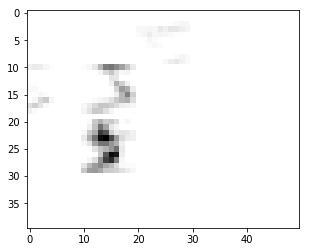

In [27]:
fList = numpy.zeros((10*4, 10*5))
i = 0
for j in range(4):
    for k in range(5):
        fList[10*j:10*(j+1), 10*k:10*(k+1)] = y3[:, :, i]
        i = i + 1
matplotlib.pyplot.imshow(fList, cmap='Greys', interpolation='None')

In [28]:
print(Images.shape)

(60000, 1, 28, 28)


In [29]:
import matplotlib.pyplot
%matplotlib inline

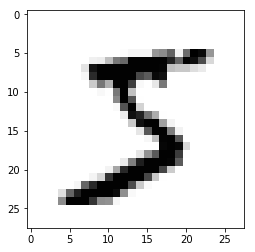

In [30]:
matplotlib.pyplot.imshow(Images[0].reshape(28, 28), cmap='Greys', interpolation='None')

In [31]:
Images[0].reshape(28, 28).shape

(28, 28)

In [32]:
Images[0].transpose(1, 2, 0).shape

(28, 28, 1)

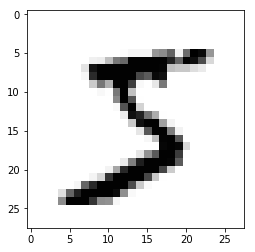

In [33]:
matplotlib.pyplot.imshow(Images[0].transpose(1, 2, 0)[:, :, 0], cmap='Greys', interpolation='None')

x.shape =  (28, 28, 1)
y.shape =  (14, 14, 1)
filterW =  [[0.25 0.25]
 [0.25 0.25]]
image.shape =  (27, 27)


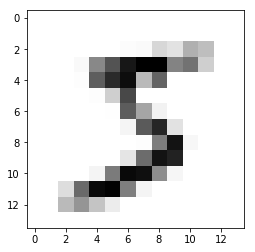

In [34]:
x = Images[0].transpose(1, 2, 0)
print("x.shape = ", x.shape)
xrow, xcol, numFilters = x.shape
y = numpy.zeros((int(xrow/2), int(xcol/2), numFilters))
print("y.shape = ", y.shape)

for k in range(numFilters):
    filterW = numpy.ones((2, 2)) / (2*2)
    print("filterW = ", filterW)
    image = scipy.signal.convolve2d(x[:, :, k], filterW, 'valid')
    print("image.shape = ", image.shape)
    y[:, :, k] = image[0:image.shape[0]:2, 0:image.shape[1]:2]

matplotlib.pyplot.imshow(y[:, :, 0], cmap='Greys', interpolation='None')

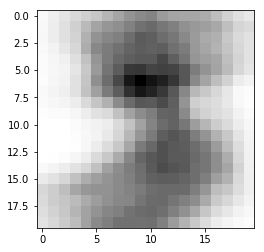

In [35]:
W = 1e-2*numpy.random.rand(9, 9, 20)
x = Images[0].transpose(1, 2, 0)

wrow, wcol, numFilters = W.shape
xrow, xcol, _ = x.shape
    
yrow = xrow - wrow + 1
ycol = xcol - wcol + 1
    
y = numpy.zeros((yrow, ycol, numFilters))
    
for k in range(numFilters):
    filterW = W[:, :, k]
    filterW = numpy.rot90(numpy.squeeze(filterW), 2)
    y[:, :, k] = scipy.signal.convolve2d(x[:, :, 0], filterW, 'valid')

matplotlib.pyplot.imshow(y[:, :, 0], cmap='Greys', interpolation='None')

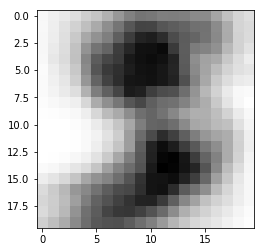

In [36]:
matplotlib.pyplot.imshow(y[:, :, 19], cmap='Greys', interpolation='None')

In [37]:
[x for x in range(1, 10, 2)]

[1, 3, 5, 7, 9]

In [38]:
Images[0].flatten().shape

(784,)

In [39]:
Labels[0]

5

In [40]:
d = numpy.zeros((10, 1))
d[Labels[0]] = 1
d

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [41]:
Images[0:8000].shape

(8000, 1, 28, 28)

In [42]:
W1

array([[[-0.02505039, -0.05115042,  0.05028991, ..., -0.04693534,
         -0.15180262, -0.02387201],
        [-0.02151995, -0.04449799,  0.03674985, ..., -0.0320071 ,
         -0.14771495, -0.00920258],
        [-0.02672969, -0.03024294,  0.03573698, ..., -0.04559175,
         -0.15507689, -0.00398497],
        ...,
        [-0.037064  , -0.03285319,  0.02009623, ..., -0.02251359,
         -0.17793426, -0.02482734],
        [-0.04739552, -0.03864062,  0.02186265, ..., -0.03361777,
         -0.1771299 , -0.05914738],
        [-0.032763  , -0.03106113,  0.04351641, ..., -0.01697489,
         -0.16368676, -0.05329179]],

       [[-0.00985715, -0.03637224, -0.00328821, ..., -0.06423124,
         -0.14510161, -0.01271495],
        [-0.00761132, -0.04257282,  0.01322614, ..., -0.05613265,
         -0.14900286, -0.00586428],
        [-0.01459336, -0.03433012,  0.02441761, ..., -0.04248457,
         -0.15689806, -0.00586652],
        ...,
        [-0.02195446, -0.0257786 , -0.00591046, ..., -

In [43]:
W5

array([[ 9.70062713e-03,  4.52537952e-03,  3.69187184e-02, ...,
         1.39895696e-02, -1.06127673e-02,  4.01016118e-02],
       [-2.03922773e-02, -2.78169576e-02, -4.67913462e-02, ...,
         1.66023137e-02,  4.51376516e-02, -3.68741828e-02],
       [ 1.84472452e-02,  1.31197768e-02,  3.65032358e-02, ...,
        -3.22841896e-02,  3.33656297e-02,  4.46409797e-02],
       ...,
       [ 1.59950868e-02,  1.02886652e-02,  3.19438877e-02, ...,
         3.06047299e-02, -4.35921875e-02,  1.79439650e-02],
       [ 2.98502537e-02,  4.28663224e-03, -3.02126342e-02, ...,
        -4.79648956e-06, -1.00879054e-02, -4.13374831e-02],
       [-2.94779469e-03, -5.41578540e-02,  2.25667668e-02, ...,
        -2.10631258e-02,  3.02304705e-02,  3.46569280e-02]])

In [44]:
Wo

array([[-3.48444153e-01, -2.53202920e-01,  2.39017378e-01,
        -7.45354135e+00,  3.89416597e-01,  8.11470281e-03,
        -2.37880821e+00, -3.57727147e-01, -1.68651266e-02,
         7.32039668e-02, -1.13269323e-01, -1.20361390e+00,
        -2.05501899e-01, -1.51599499e-01,  3.01231804e-01,
        -1.45410110e-01, -1.64634666e-01, -1.46431362e-01,
         6.03380298e-02, -6.07192308e-02, -6.23943587e-02,
         1.28726542e-01, -7.66733683e-02,  2.11484057e-01,
         2.72531775e-01, -3.21493912e+00,  4.24495963e-01,
        -1.08866335e-01,  2.02976713e-01, -5.46019376e-02,
        -3.31326142e+00, -5.62001606e-02, -1.52274050e-01,
        -2.38518233e+00,  8.07597852e-02, -9.92461252e-02,
        -1.42179312e-01, -1.60978591e-01, -3.99931577e-01,
        -1.74990114e-01, -3.17789343e+00,  4.25733892e-02,
         1.37866047e-01, -2.96656015e-02,  1.18916326e-01,
        -2.04075107e+00, -9.47463644e-01, -8.92206208e-02,
        -1.61140013e-01,  1.80454401e-01, -1.31306027e-0

In [45]:
e2 = numpy.zeros((20, 20, 20))
e3 = numpy.random.rand(10, 10, 20)
W3 = numpy.random.rand(20, 20, 20)
for c in range(20):
    e2[:, :, c] = scipy.sparse.kron(e3[:, :, c], numpy.ones((2, 2))) * W3[:, :, c]

In [46]:
e2.shape

(20, 20, 20)

In [49]:
t = numpy.arange(20)

In [50]:
s = t.reshape((2,2,5))
s

array([[[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9]],

       [[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]]])

In [51]:
r = s.reshape((2,5,2))
r

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9]],

       [[10, 11],
        [12, 13],
        [14, 15],
        [16, 17],
        [18, 19]]])